# Generative Deep Learning

The potential for AI to emulate human thought process goes byond passive tasks such as object recognition and mostly reactive tasks such as driving a car. It extends well into creative activities.\
Granted, the artistic productions we have seen from AI so far have been fairly low quality. AI isn't anywhere close to rivaling human screenwriters, painters, and composers. But replacing humans was always beside the point: artificial intelligence is no about replacing our own intelligence with something else, it's about bringing into our lives and work more intelligence- intelligence of a different kind. In many fields, but especially in creative ones, AI will be used by humans as a tool to augment their own capabilities: more augmented intelligence than artificial Intelligence.\
A large part of artistic creation consists of simple pattern recognition and technical skill. And that's precisely the part of the process that many find less attractive or even dispensable. That's where AI comes in. Our perceptual modalities, our language, and our artwork all have statistical structure. Learning this structure is what deep learning algos excel at. Machine learning models can learn the statistical latent space of images, music and stories and they can then sample from this space, creating new art.\
Naturally, such sampling is hardly an act of artistic creation in itself. It is a mere mathematical operation: the algorithm has no grounding in human life, human emotions, or our experience of the world, instead, it learns from an experience that has little in common with ours. It is only our interpretation, as human spectators, that will give meaning to what the model generates. But in the hands of a skilled artist, algorithmic generation can be steered to become meaningful. Latent space sampling can become a brush that empowers artist, augments our creative affordances, and expands the space of what we can imagine. What's more, it can make artistic creation more accessible by eliminating the need for technical skill and practice.
In this chapter, we'll explore from various angles the potential of deep learning to augment artistic creation. We will review sequence data generation, DeepDream, and image generation using both variational autoencoders and generative adversarial networks.

## Text Generation
In this section, we'll explore how RNN can be used to generate sequence data. We'll use text generation as an example, but the exact same techniques can be generalized to any kind of sequence data: you could apply it to sequences of musical notes in order to generate music, to timeseries of brush stroke data to generate paintings, and so on.\
Sequence data generation is in no way limited to artistic content generation. It has been successfully applied to speech synthesis and to dialogue generation for chatbots.

### How do you generate Sequence Data?

The universal way to generate sequence data in DL is to train a model to predict the next token or next few tokens in a sequence, using the previous tokens as input. For instance, given the input "The cat is on the", the model is trained to predict the target "mat", the next word. As usual when working with text data, tokens are typically words or characters, and any network that can model the probability of the next token given the previous ones is called a lenguage model. A language model capture latent space of language: its statistical structure.\
Once you have such a trained language model, you can sample from it: you feed it an initial string of text, ask it to generate the next character or thenext word, add the generated output back to the input data, and repeat. This loop allows to generate sequences of arbitrary length that reflect the structure of the data on which the model was trained: sequences that look almost like human-written sentences.\
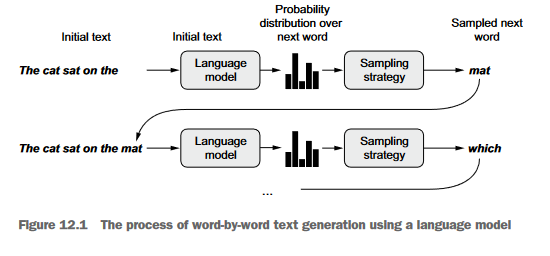


### The importance of sampling strategy

When generating text, the way you choose the next token is crucially important. A naive approach is greedy sampling, consisting of always choosing the most likely next character. But such an approach results in repetitive, predictable strings that don't look like coherent language. A more interesting approach makes slightly more surprising choices: it introduces randomness in the sampling process by sampling from the probability distribution for the next charavter. This is called stochastic sampling (Stochastic=Random). In such a setup, if a word has probability 0.3 of being next in the sentence according to the model, you will choose it 30% of the time. Note that greedy samplign can also be cast as sampling from a probability distribution.\
Sampling probabilistically from the softmax output of the model is neat: it allows even ulikely words to be sampled some of the time, generating more interesing looking sentences and sometimes showing creativity by coming up with new, realistic sounding sentences that did not occur in the training data. But there is one issue with this strategy: it does not offer a way to control the amount of randomness in the sampling process.\
Sampling from "real" probability distribution, the distribution tha tis output by the model's softmax function, constitutes an intermediate point between these two extremes. But there are many other intermediate points of higher or lower entropy that you may want to explore. Less entropy will give the generated sequences a more predictable structurem whereas more entropy will result in more surprising and creative sequences. When sampling from generative models, it is always good to explore different amounts of randomness in the generation process.\
In order to control the amount of stochasticity in the sampling process, we'll introduce a parameter called the softmax temperature, which characterizes the entropy of the probability distribution used for sampling: it characterizes how surpirising or predictable the chice of the next word will be. Given a temperature value, a new probability distribution is computed from the original one by reweighting it in the following way.

In [ ]:
import numpy as np
def reweigth_distribution(original_dist, temperature=0.5):
  distribution = np.log(original_dist)/temperature
  distribution = np.exp(distribution)
  return distribution / np.sum(distribution)

Higher temperatures result in sampling distributions of higher entropy that will generate more surprising and unstructured generated data, whereas lower temperature will result in less randomness and much more predictable generated data.\
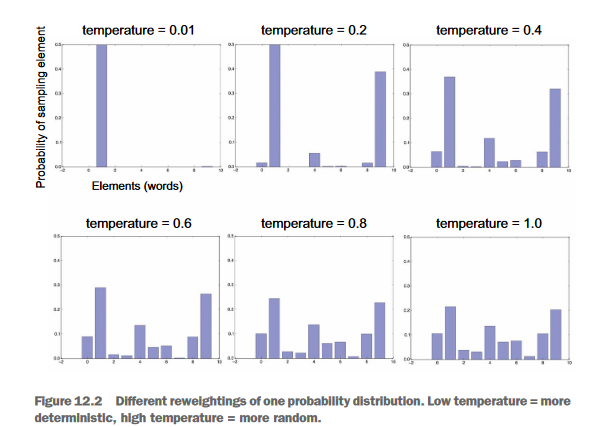

###Implementing Text generation in Keras

Let's put these ideas into practive in Keras implementation. The first thing you need is a lot of text data that you can use to learn a language model. You can use any sufficiently large text file or set of text files.\

#### Preparing the data
Let's download and uncompress the IMDB movie review dataset

In [ ]:
!wget https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!tar -xf aclImdb_v1.tar.gz

--2023-07-18 07:38:38--  https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
Resolving ai.stanford.edu (ai.stanford.edu)... 171.64.68.10
Connecting to ai.stanford.edu (ai.stanford.edu)|171.64.68.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84125825 (80M) [application/x-gzip]
Saving to: ‘aclImdb_v1.tar.gz’

aclImdb_v1.tar.gz   100%[===================>]  80.23M  22.6MB/s    in 3.5s    

2023-07-18 07:38:42 (22.6 MB/s) - ‘aclImdb_v1.tar.gz’ saved [84125825/84125825]



In [ ]:
#Creatuing a dataset from text files (one file = one sample)

import tensorflow as tf
from tensorflow import keras

dataset = keras.utils.text_dataset_from_directory(
    directory="aclImdb", label_mode = None, batch_size = 256
)
dataset = dataset.map(lambda x: tf.strings.regex_replace(x, "<br />"," "))

Found 100006 files belonging to 1 classes.


Now we use TextVectorization layer to compute the vocabulary we will be working with. We will only use the first sequence_length words of each review: out TextVectorization layer will cut off anything beyond that when vectorizing a text.

In [ ]:
from tensorflow.keras.layers import TextVectorization

sequence_length = 100
vocab_size = 15000
text_vectorization  = TextVectorization(
    max_tokens = vocab_size,
    output_mode = "int",
    output_sequence_length=sequence_length
)
text_vectorization.adapt(dataset)

Let's use the layer to reate a language modeling dataset where input samples are vectorized texts, and corresponding targets are the same texts offset by one word.

In [ ]:
#Setting up language modeling dataset

def prepare_lm_dataset(text_batch):
  vectorized_sequences = text_vectorization(text_batch)
  x = vectorized_sequences[:, :-1]
  y = vectorized_sequences[:,1:]
  return x,y

lm_dataset = dataset.map(prepare_lm_dataset, num_parallel_calls=4)

#### Transformer based Seq2Seq model
We will train amodel to predict a probability distribution over the next word in a sentence, given a number of initial words. When the model i trained, we will feed it with a prompt, sample the next word, add that word back to the prompt, and repeat, until we have generated a short paragraph.\
We could train a model that takes as input a sequence of N words and simply predicts word N+1. However, there are several issues with this setup in the context of sequence generation.\
First, the model would only learn to produce predictions when N words were available, but it would be useful to be able to start predicting with fewer than N words. Otherwise we would be constrained to only use relatively long prompts.\
Second, many of our training sequences will be mostly overlapping. Consider N=4. The text "A complete sentence must have, at minimum, three things: a subject, verb, and an object" would be used to generate the following training sequences:
* "A complete sequence must"
* "complete sentence must have"
* "sentence must have at"
* and so on, until "verb and object"

A model that treats each such sequence as an independent sample would have to do a lot of redundant work, re-encoding multiple times subsequences that it has largely seen before. We could try to allebiate this redundancy problem by using strides to sample our sequences, skipping a few words between two consecutive samples. But that would reduce our number of training samples while only providing a partial solution.\
To address these two issues, we will use a seq2seq model: we will feed sequences of N words into our model, and we will predict the sequence offset by one. We will use causal masking to make sure that, for any i, the model will only be using words from 0 to i in order to predict the word i+1. Thi means that we are simultaneously training the model to solve N mostrly overlapping but different problems: predicting the next words given a sequence of 1<=i<=N prior words. At generation time, even if you only prompt the model with a single word, it would be able to give you a probability distribution for the next possible words.\
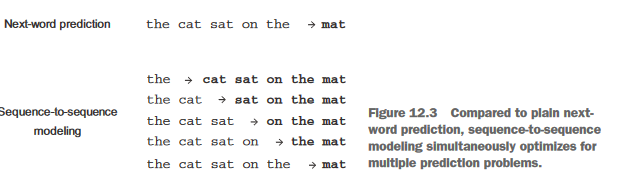
In the previous chapter, you learned about the setup you can use for seq2seq learning in general case: feed the source sequence into an encoder, and then feed both the encoded sequence and the target sequence into a decoder that tries to predict the same target sequence offset by one step. When you are doing text generation, there is no source sequence: you are just trying to predict the next tokens in the target sequence given past tokens, which we can do using only the decoder. And thanks to causal padding, the decoder will only look at words 0..N to predict the word N+1.


In [ ]:
#Positional Embedding Layer

class PositionalEmbedding(layers.Layer):
  def __init__(self, sequence_length, input_dim, output_dim, **kwargs):
    super().__init__(**kwargs)
    self.token_embeddings = layers.Embedding(input_dim=input_dim, output_dim=output_dim)
    self.position_embeddings =layers.Embedding(input_dim=sequence_length, output_dim=output_dim)
    self.sequence_length = sequence_length
    self.input_dim=input_dim
    self.output_dim=output_dim

  def call(self,inputs):
    length = tf.shape(inputs)[-1]
    positions = tf.range(start=0, limit=length, delta=1)
    embedded_tokens = self.token_embeddings(inputs)
    embedded_positions = self.position_embeddings(positions)
    return embedded_tokens + embedded_positions

  def compute_mask(self, inputs, mask=None):
    return tf.math.not_equal(inputs,0)

  def get_config(self):
    config = super().get_config()
    config.update({
        "output_dim": self.output_dim,
        "sequence_length": self.sequence_length,
        "input_dim": self.input_dim,
    })
    return config

In [ ]:
#Transformer Decoder

class TransformerDecoder(layers.Layer):

  def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
    super().__init__(**kwargs)
    self.embed_dim = embed_dim
    self.dense_dim = dense_dim
    self.num_heads = num_heads
    self.attention_1 = layers.MultiHeadAttention(num_heads = num_heads, key_dim=embed_dim)
    self.attention_2 = layers.MultiHeadAttention(num_heads = num_heads, key_dim=embed_dim)
    self.dense_proj = keras.Sequential([layers.Dense(dense_dim, activation="relu"), layers.Dense(embed_dim)])
    self.layernorm_1 = layers.LayerNormalization()
    self.layernorm_2 = layers.LayerNormalization()
    self.layernorm_3 = layers.LayerNormalization()
    self.supports_masking=True

  def get_config(self):
    config = super(TransformerDecoder, self).get_config()
    config.update({
        "embed_dim": self.embed_dim,
        "num_heads": self.num_heads,
        "dense_dim": self.dense_dim,
    })
    return config

  def get_causal_attention_mask(self,inputs):
    input_shape=tf.shape(inputs)
    batch_size, sequence_length = input_shape[0], input_shape[1]
    i = tf.range(sequence_length)[:, tf.newaxis]
    j = tf.range(sequence_length)
    mask = tf.cast(i >= j, dtype="int32")
    mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
    mult = tf.concat(
        [tf.expand_dims(batch_size, -1),
         tf.constant([1,1], dtype=tf.int32)], axis=0
    )
    return tf.tile(mask, mult)

  def call(self, inputs, encoder_outputs, mask=None):
    causal_mask= self.get_causal_attention_mask(inputs)
    if mask is not None:
      padding_mask = tf.cast(
          mask[:,tf.newaxis, :],dtype="int32"
      )
      padding_mask = tf.minimum(padding_mask, causal_mask)
    else:
      padding_mask = mask

    attention_output_1 = self.attention_1(query=inputs, value=inputs, key=inputs, attention_mask=causal_mask)
    attention_output_1 = self.layernorm_1(attention_output_1)
    attention_output_2 = self.attention_2(query=attention_output_1, value=encoder_outputs, key=encoder_outputs, attention_mask=padding_mask)
    attention_output_2 = self.layernorm_2(attention_output_1 + attention_output_2)
    proj_output = self.dense_proj(attention_output_2)
    return self.layernorm_3(attention_output_2 + proj_output)

In [ ]:
from tensorflow.keras import layers
embed_dim=256
latent_dim=2048
num_heads=2

inputs=keras.Input(shape=(None,), dtype="int64")
x = PositionalEmbedding(sequence_length, input_dim=vocab_size, output_dim=embed_dim)(inputs)
x = TransformerDecoder(embed_dim, latent_dim, num_heads)(x,x)
outputs=layers.Dense(vocab_size, activation="softmax")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="sparse_categorical_crossentropy", optimizer="rmsprop")

### A text-generation callback with variable-temperature sampling

We will use a callback to generate text using a range of different temperatures after every epoch. This allows you to see how the generated text evolves as the model begins to converge, as well as the impact of temperature in the sampling strategy. To seed text generation, we will use the prompt "this movie:" all of our generated texts will start with this

In [ ]:
import numpy as np

tokens_index = dict(enumerate(text_vectorization.get_vocabulary()))

def sample_next(predictions, temperature=1.0):
  predictions = np.asarray(predictions).astype("float64")
  predictions = np.log(predictions) / temperature
  exp_preds = np.exp(predictions)
  predictions = exp_preds / np.sum(exp_preds)
  probas = np.random.multinomial(1, predictions,1)
  return np.argmax(probas)

class TextGenerator(keras.callbacks.Callback):

  def __init__(self, prompt, generate_length, model_input_length, temperatures=(1.,), print_freq=1):
    self.prompt=prompt
    self.generate_length = generate_length
    self.model_input_length = model_input_length
    self.temperatures = temperatures
    self.print_freq = print_freq

  def on_epoch_end(self, epoch, logs=None):
    if (epoch + 1) % self.print_freq != 0:
      return
    for temperature in self.temperatures:
      print("==Generating with temperature", temperature)
      sentence = self.prompt
      for i in range(self.generate_length):
        tokenized_sentence = text_vectorization([sentence])
        predictions = self.model(tokenized_sentence)
        next_token = sample_next(predictions[0,i,:])
        sampled_token = tokens_index[next_token]
        sentence += " " + sampled_token
      print(sentence)

In [ ]:
prompt = "This movie"
text_gen_callback = TextGenerator(prompt, generate_length=50,model_input_length=sequence_length, temperatures=(0.2,0.5,0.7,1.,1.5))

In [ ]:
model.fit(lm_dataset, epochs=200, callbacks=[text_gen_callback])

Epoch 1/200
391/391 [==============================] - ETA: 0s - loss: 6.5708==Generating with temperature 0.2
This movie movie is a thank great pay always system white story good is not or hall what ever same good personally another of on scene of this berry that be the sure i for when hour reno recent was than selling memories least what nothing for this that the with who
==Generating with temperature 0.5
This movie formulaic kevin movie is rent about there course this to rodeo film airplanes first can one [UNK] death can have has superbly [UNK] a the i anything done you a audience narnia wanna show righteous in fight watch nonsensical saw of movement 70s of still had in its enjoyed a
==Generating with temperature 0.7
This movie has socalled not is that appealing absolutely [UNK] be me it done orchestral example is bad one funny on bad like [UNK] plot one other those and remains seated and the id even i but copy by to the didnt minutes ended studio had fans several the school the be


A low temperature value results in very boring and repetitive text and can sometimes cause the generation process to get stuck in a loop. With higher temperatures, the generated text becomes more interesting, surprising, even creative. With a very high temperature, the local structure starts to break down, and the output looks largely random. Here, a good generation temperature would seem to be about 0.7. Always experiment with multiple sampling strategies! A clever balance between learned structure and randomness is what makes generation interesting.\
By Training a bigger model, longer, on more data, you can achieve generated samples that look far more coherent and realistic than this one. But don't expect to ever generate any meaningful text, other than through random chance and the magic of your own interpretation: all you are doing is sampling data from a statistical model of which words come after which words. Language models are all form and no substance.\
What language models do is capture the statistical structure of the observable artifacts that we generate as we use language to live our lives. The fact that these artifacts have a statistical structure at all is a side effect of how humans implement language.

### Wrapping up
* You can generate discrete sequence data by training a model to predict the next token, given previous tokens.
* In the case of text, such a model is called a language model. It can be based on either words or characters.
* Sampling the next token requires a balance between adhering to what the model judges likely, and introducing randomness.
* One way to handle this is the notion of softmax temperature. Always experiment with different temperatures to find the right one.

### Deep Dream

DeepDream is an artistic image-modification techinque that uses representations learned by convolutional NN.\
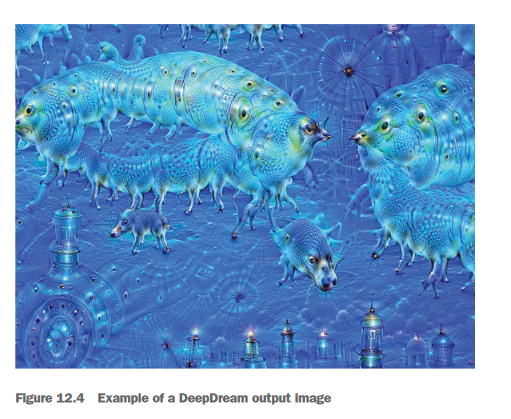
The DeepDream algorithm is almost identical to a convnet filter-visualization,consisting of running a convet in reverse: doing gradient ascent on the input to the convnet in order to maximize the activation of a specific filter in an upper layer of the net. DeepDream uses this same idea, with a few simple differences:
* With DeepDream, you try to maximize the activation of entire layers rather than that of specific filter, whus miximng tofether visualizations of large numbers of features at once
* You start not from blank, slightly noisy input, but rather from an existing image - thus the resulting effetcs latch on to preexisting visual patterns, distorting elements of the image in a somewhat artistic fashion.
* The input images are processed at different scales (octaves), which improves the quality of the visualizations.

### Implementing DeepDream in Keras
We start by retrieving a test image.

In [ ]:
#Fetch test image
from tensorflow import keras
import matplotlib.pyplot as plt

base_image_path = keras.utils.get_file(
    "coast.jpg", origin="https://img-datasets.s3.amazonaws.com/coast.jpg"
)

plt.axis("off")
plt.imshow(keras.utils.load_image(base_image_path))

Next we need a pretrained convnet. In Keras, many such convnets are available: VGG16, VGG19, Xception, and so on, all available with weights pretrained on ImageNet. You can implement DeepDream with any of themm but your base model of choice will naturally affect your visualizations, because different architectures result in different learned features. The convnet used in the original DeepDream release was Inception  model, and in practice, Inception is known to produce nice-looking DeepDreams.

In [ ]:
#Instantiate pretrained InceptionV3 model

from tensorflow.keras.applications import inception_v3
model = inception_v3.InceptionV3(weights="imagenet", include_top=False)

We will use our pretrained convnet to create a feature extractor model that returns the activations of the various intermediate layers, listed in the following code. For each layer, we pick a scalar score that weigts the contribution of the layer to the loss we will seek to maximize during the gradient ascent process.

In [ ]:
layer_settings = {
    "mixed4": 1.0,
    "mixed5": 1.5,
    "mixed6": 2.0,
    "mixed7": 2.5
}

outputs_dict = dict(
    [
        (layer.name, layer.output)
        for layer in [model.get_layer(name)
                      for name in layer_settings.keys()]
    ]
)
feature_extractor = keras.Model(inputs=model.inputs, outputs=outputs_dict)

Next we compute the loss: the quantity we will seek to maximize during the gradient ascent process at each processing scale. We will simultaneously maximize the activation of all filters in a number of layers. Specifically, we will maximize a weighted mean of the L2 norm of the activations of a set of high-level layers. The exact set of layers we choose has a major influence on the visuals we will be able to reproduce, so we want to make these parameters easily configurable. Lower layers result in geometric patterns, whereas higher layers result in visuals in which you can recognize some classes from ImageNet. We will start from a somewhat arbitrary configuration involving four layers.

In [ ]:
#The DeepDream loss

def compute_loss(input_image):
  features = feature_extractor(input_image)
  loss = tf.zeros(shape=())
  for name in features.keys():
    coeff = layer_settings[name]
    activation = features[name]
    loss += coeff * tf.reduce_mean(tf.square(activation[:,2:-2,2:-2,:]))
  return loss

Now we set up gradient ascent process that we will run at each octave. You will recognize that it is the same thing as the filter-visualization technique.DeepDream algorithm is simply a multiscale form of filter visualization

In [ ]:
#DeepDream gradient ascent process

import tensorflow as tf

@tf.function
def gradient_ascent_step(image, learning_rate):
  with tf.GradientTape() as tape:
    tape.watch(image)
    loss = compute_loss(image)
  grads = tape.gradient(loss, image)
  grads = tf.math.l2_normalize(grads)
  return loss, image

def gradient_ascent_loop(image, iterations, learning_rate, max_loss=None):
  for i in range(iterations):
    loss, image = gradient_ascent_step(image, learning_rate)
    if max_loss is not None and loss > max_loss:
      break
    print(f"... Loss value at step {i}: {loss:.2f}")
  return image

Finally, the outer loop of the algorithm. First we define a list of scales(octaves) at which to process the images. We will process our image over three different octaves. For each octave, from the smallest to the largest, we will run 20 Gradient ascent steps via gradient_ascent_loop() to maximize the loss. Between each octave, we will upscale the image by 40\%: we will start by processing a small image and then increasingly scale it up.\
We define the params of this process in the following code. Tweaking these params will allow to achieve new effects!
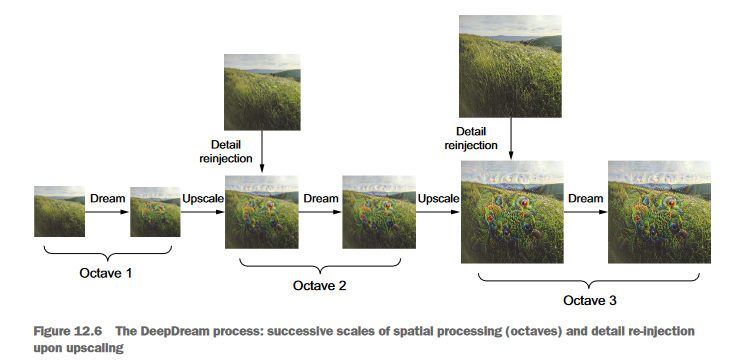

In [ ]:
step = 20.
num_octave = 3
octave_scale = 1.4
iterations = 30
max_loss = 15.

import numpy as np

def preprocess_image(image_path):
  img = keras.utils.load_img(image_path)
  img = keras.utils.img_to_array(img)
  img = np.expand_dims(img, axis=0)
  img = keras.applications.inception_v3.preprocess_input(img)
  return img

def deprocess_image(img):
  img = img.reshape((img.shape[1], img.shape[2], 3))
  img /= 2.0
  img += 0.5
  img *= 255.
  img = np.clip(img, 0, 255).astype("uint8")
  return img

This is the outer loop. To avoid using a lot of image detail after each successive scale-up, we can use a simple trick:\
after each scale-up, we will re-inject the lost details back into the image, which is possible because we know what the original image should look like at the larger scale. Given a small image size S and a larger size L, we can compute the difference between the original image resized to size L and the original resized to size S - this difference quantifies the details lost when going from S to L.

In [ ]:
# Running gradient ascent over multiple successive "octaves"

original_img = preprocess_image(base_image_path)
original_shape = original_img.shape[1:3]

successive_shapes = [original_shape]
for i in range(1, num_octave):
  shape = tuple([int(dim / (octave_scale ** i)) for dim in original_shape])
  successive_shapes.append(shape)
successive_shapes = successive_shapes[::-1]

shrunk_original_img = tf.image.resize(original_img, successive_shapes[0])

img = tf.identity(original_img)
for i, shape in enumerate(successive_shapes):
  print(f"Processing octave {i} with shape {shape}")
  img = tf.image.resize(img, shape)
  img = gradient_ascent_loop(
      img, iterations=iterations, learning_rate = step, max_loss=max_loss
  )
  upscaled_shrunk_original_img = tf.image.resize(shrunk_original_img, shape)
  same_size_original = tf.image.resize(original_img, shape)
  lost_detail = same_size_original - upscaled_shrunk_original_img
  img +=  lost_detail
  shrunk_original_img = tf.image.resize(original_img, shape)

keras.utils.save_img("dream.png", deprocess_image(img.numpy()))

Layers that are lower in the network contain more-local, less-abstract representations and lead to dream patterns that look more geometric. Layers that are higher up lead to more-recognizable visual patterns based on the most common objects found in ImageNet, such as dog eye, bird feathers, and so on. You can use random generation of the parameters in the layer_settings dictionary to quickly explore many different layer combinations.

### Wrapping up
* DeepDream consists of running a convnet in reverse to generate inputs based on the representations learned by the network.
* The results produced are fun and somewhat similar to the visual artifacts induced in humans by the distruption of the visual cortex via psychedelics
* Note that the process is not specific to image models or convnets. It can be done for speech, music and moreù

## Neural Style Transfer
In addition to DeepDream, another major development in deep-learning-driven image modification is neural style transfer. The neural style transfer algorithm has undergone many refinements and spawned many variations since its original introduction, and it has made its way into many smartphone photo apps. For simplicity, this section focuses on the formulation described in the original paper.\
Neural style transfer consists of applying the style of a reference image to a target image while conserving the content of the target image. In this context, style essentially means textures, colors, and visual patterns in the image, at various spatial scales, and the content is the higher-level macrostructure of the image.\
The idea of style transfer, which is tightly related to that of texture generation, has had a long history in the image-processing community prior to the development of neural style transfer. But as it turn out, the deep-learning-based implementations of style transfer offer results unparalleled by what had been previously achieved with classical computer vision techniques, and they triggered an amazing renaissance in creative application of CV.\
The key notion behind implementing style transfer is the same idea that's central to all deep learning algorithms: you define a loss function to specify what you want to achievem and you minimize this loss. We know what we want to achieve: conserving the content of the original image while adopting the style of the reference image. If we were able to mathematically define content and style, then an appropriate loss function to minimize would be the following:


In [ ]:
loss = (distance(style(reference_image)-style(combination_image))+
        distance(content(original_image)-content(combination_image)))

Here, distance is a norm function such as the L2 norm, content is a function that takes an image and computes a representation of its content, and style is a function that takes an image and computes a representation of its style. Minimizing this loss causes style(combination_image) to be close to style(reference_image), and content(combination_image) is close to content(original_image), thus achieving style transfer as we defined it.\
A fundamental observation made was that deep convolutional neural networks offer a way to mathematically define the style and content functions.

### The content loss

Activations from earlier layers in a network contain local information about the image, whereas activations from higher layers contain increasingly global, abstract information. Formulated in a different way, the activations of the different layers of a convnet provide a decomposition of the contents of an image over different spatial scales. Therefore, you would expect the content of an image, which is  more global and abstract, to be captured by the represetnations of the upper layers in a convnet.\
A good candidate for content loss is thus the L2 norm between the activations of an upper layer in a pretrained convnet, computed over the target image, and the activations of the same layer computed over the generated image. This guarantees that, as seen from the upper layer, the generated image will look similar to the original target image. Assuming that what the upper layers of a convnet see is really the content of their input images, this works as a way to preserve image content.

### The style loss

The content loss only uses a single upper layer, but the style loss as defined uses multiple layers of a convnet: you try to capture the appearance of the style-reference image at all spatial scales extracted by the convnet, not just a single scale. For the style loss, use the Gram matrix of a layer's activations: the inner product of the feature maps of a given layer. This inner product can be understood as representing a map of the correlations between the layer's features. These feature correlations capture the statistics of the patterns of a particular spatial scale, which empirically correspond to the appearance of the textures found at this scale.\
Hence, the style loss aims to preserve similar internal correlations within the activations of different layers, across the style-reference image and the generated image.\
In short, you can use a pretrained convnet to define a loss that will do the following:
* Preserve content by maintaining similar high-level layer activations between the original image and the generated image. The convnet should "see" both the original image and the generated image as containing the same things.
* Preserve style by maintaining similar correlations within activations for both low-level layers and high-level layers. Feature correlations capture textures: the generated image and the style-reference image should share the same textures at different spatial scales.

### Neural style transfer in Keras

Neural style transfer can be implemented using any pretrained convnet. Here, we will use VGG19 network, which is a simple variant of the VGG16 network, with three more conv layers.\
Here's the general process:
* Set up a network that computes VGG19 layer activations for the style-reference image, the base image, and the generated image at the same time.
* Use the layer activations computed over these three images to define the loss function described earlier, which we will minimize in order to achieve style transfer.
* Set up a gradient-descent process to minimize this loss function.

We start by defining the paths to the style-reference image and the base image.

In [ ]:
from tensorflow import keras

base_image_path = keras.utils.get_file("sf.jpg", origin="https:/ /img-datasets.s3.amazonaws.com/sf.jpg")
style_reference_image_path = keras.utils.get_file(
"starry_night.jpg",
origin="https:/ /img-datasets.s3.amazonaws.com/starry_night.jpg")

original_width, original_height = keras.utils.load_img(base_image_path).size
img_height=400
img_width = round(original_width*img_height/original_height)

In [ ]:
#Auxiliary functions

import numpy as np

def preprocess_image(image_path):
    img = keras.utils.load_img(image_path, target_size=(img_height, img_width))
    img = keras.utils.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = keras.applications.vgg19.preprocess_input(img)
    return img

def deprocess_img(img):
    img = img.reshape((img_height, img_width, 3))
    img[:,:,0] += 103.939
    img[:,:,1] += 116.779
    img[:,:,2] += 123.68
    img = img[:,:,::-1]
    img = np.clip(img,0,255).astype("uint8")
    return img

In [ ]:
# Using pretrained VGG19 model to create feature extractor

model = keras.applications.vgg19.VGG19(weights="imagenet", include_top=False)
outputs_dict = dict([(layer.name,layer.output) for layer in model.layers])
feature_extractor=keras.Model(inputs=model.inputs, outputs=outputs_dict)

In [ ]:
# Content loss
def content_loss(base_img, combination_img):
    return tf.reduce_sum(tf.square(combination_img - base_img))

In [ ]:
#Style loss

def gram_matrix(x):
    x = tf.transpose(x,(2,0,1))
    features = tf.reshape(x, (tf.shape(x)[0],-1))
    gram = tf.matmul(features, tf.transpose(features))
    return gram

def style_loss(style_img, combination_img):
    S = gram_matrix(style_img)
    C = gram_matrix(combination_img)
    channels=3
    size = img_height * img_width
    return tf.reduce_sum(tf.square(S-C)) / (4.0 * (channels ** 2) * (size ** 2))



To these two loss components, you add a third: the total variation loss, which operates on th epixels of the generated combination image. It encourages spatial continuity in the generated image, thus avoiding overly pixelated results. You can interpret it as a regularization loss.

In [ ]:
#Total variation loss

def total_variation_loss(x):
    a = tf.square(
        x[:,:img_height-1,:img_width-1,:] - x[:,1:,:img_width-1,:]
    )
    b = tf.square(
        x[:,:img_height-1,:img_width-1,:]-x[:,:img_height-1,1:,:]
    )
    return tf.reduce_sum(tf.pow(a+b,1.25))

The loss you minimize is a weighted average of these three losses. To compute the content loss, you use only one upper layer, the block5_conv2 layer, whereas for the style loss, you use a list of layers that spans both low-level and high-level layers. You add the total variation loss at the end.\
Depending on the style-reference image and content image you are using, you will likely want to tune the content_weight coefficient. A higher content_weight means the target content will be more recognizable in the generated image.

In [ ]:
#Defininig the final loss that you will minimize

style_layer_names = [
    "block1_conv1",
    "block2_conv1",
    "block3_conv1",
    "block4_conv1",
    "block5_conv1"
]

content_layer_name = "block5_conv2"
total_variation_weight = 1e-6
style_weight = 1e-6
content_weight=2.5e-8

def compute_loss(combination_image, base_image, style_reference_image):
    input_tensor = tf.concat(
        [base_image, style_reference_image, combination_image], axis=0
    )
    features = feature_extractor(input_tensor)
    loss = tf.zeros(shape=())
    layer_features = feature[content_layer_name]
    base_image_features = layer_features[0,:,:,:]
    combination_features = layer_features[2,:,:,:]
    loss = loss + content_weight * content_loss(
        base_image_features, combination_features
    )
    
    for layer_name in style_layer_names:
        layer_features = features[layer_name]
        style_reference_features = layer_features[1,:,:,:]
        combination_features = layer_features[2,:,:,:]
        style_loss_value = style_loss(style_reference_features, combination_features)
        loss += (style_weight / len(style_layer_names)) * style_loss_value

    loss += total_variation_weight * total_variation_loss(combination_image)
    return loss

Finally, let's set up the gardient-descent process. In the original paper, otpimization is performed using the L-BFGS algorithm, but that's not available in Tensorflow, so we just do mini-batch gradient descent with SGD optimizer instead. We will leverage an optimizer feature we have not seed before: a lerarning-rate schedule. We will use it to gradually decrease the learning rate from a very high value to a much smaller final value. That way, we will make fast progress in the early stages of training and then proceed more cautiously as we get closer to the loss minimum.

In [ ]:
#Setting up gradient-descent
import tensorflow as tf

@tf.function
def compute_loss_and_grads(combination_image, base_image, style_reference_image):
    with tf.GradientTape() as tape:
        loss = compute_loss(combination_image, base_image, style_reference_image)
    
    grads = tape.gradient(loss, combination_image)
    return loss, grads

optimizer = keras.optimizer.SGD(
    keras.optimizers.schedulers.ExponentialDecay(initial_learning_rate=100.0, decay_steps=100, decay_rate=0.96)
)

base_image = preprocess_image(base_image_path)
style_reference_image = proprocess_image(style_reference_image_path)
combination_image = tf.Variable(preprocess_image(base_image_path))

iterations = 4000
for i in range(1, iterations+1):
    loss, grads = compute_loss_and_grads(combination_image, base_image, style_reference_image)
    optimizer.apply_gradients([(grads, combination_image)])
    if i % 100 == 0:
        print(f"Iteration {i}: loss={loss:.2f}")
        img = deprocess_image(combination_image.numpy())
        fname = f"combination_image_at_iteration_{i}.png"
        keras.utils.save_img(fname, img)

Keep in mind that what this technique achieves is merely a form of image retextyring or texture transfer. It words best with style-reference images that are strongly textured and highly self-similar, and with content targets that do not require high levels of detail in order to be recognizable. It typically can't achieve fairly abstract feats such as transferring the style of one portraint to another. The algorithm is closer to calssical signal processing than AI.\
Additionally, note that this style-transfer algo is slow to run. But the transformation operated by the setup is simple enough that it can be learned by a small, fast feedforward convnet as well. Fast style transfer can thus be achieved by first spending a lot of compute cycles to generate in-out training examples for a fixed style-reference image, using the method outlined here, and training a simple convnet to learn this style-specific transformation. Once that's done, stylizing a given image is instantaneous.

## Generating images with Variational Autoencoders

The most popular and successful application of creatinve AI today is image generation: learning latent visual spaces and sampling from them to create entirely new pictures interpolated from real ones- pictures of imageinary people, places, cats and dogs, and so on.\
In this section and the next, we will review some high-level concepts pertraining to image generation, alongside implemetnation details relative to the two main techniques in this domain: variational autoencoders(VAEs) and generative adversarial networks(GANs). Note that the techniques presented here are not specific to images. In practice, the most interesting results have been obtained with pictures, and that's what we'll focus on here.

### Sampling from latent spaces of images
The key idea of image generation is to develop a low-dimensional latent space of represetnations( a vector space), where any point can be mapped to a "valid" image: an image that looks like the real thing. The module capable of realizing this mapping, taking as input a latent point and outputting an image, is called a generator(GAN) or decoder(VAE). Once such latent space has been learned, you can sample points from it, and by mapping them back to image space, generate images that have been never seen before. These new images are the in-betweens of the training images.\
GANs and VAEs are two different strategies for learning such latent spaces of image representations, each with its own characteristics. VAEs are great for learning latent spaces that are well structured, where specific directions encode a meaningful axis of variation in the data. GANs generate images that can potentially be highly realistic, but the latent space they come from may not have as much structure and continuity.

### Concept vectors for image editing

We already hinted at the idea of a concept vector when we covered word embeddings. The idea is still the same: given a latent space of representations, or an embedding space, certain directions in the space may encode interesting axes of variation in the original data. In a latent space of images of faces, for instance, there may be a smile vector, such that if latent point z is the embedded representation of a certain face, then latent point z + s is the embedded representation of the same face, smiling.\
Once you have identified such a vector, it then becomes possible to edit images by projecting them into the latent space, moving their representation in a meaningful way, and the decoding them back to image space. There are concept vectors for essentially any independent dimension of variation in image space.

### Variational Autoencoders
A kind of generative model that is especially appropriate for the task of image editing via concept vectors. They are a modern take on autoencoders that mixes ideas from deep learning with Bayesian inference.\
A classical image autoencoder takes an image, maps it to a latent vector space via an encoder module, and then decodes it back to an output with the same dimensions as the original image, via a decoder module. It's then trained by using as target data the same images as the input images, meaning the autoencoder learns to reconstruct the original inputs. By imposing various constraints on the code, you can get the autoencoder to learn more or less interesting latent representations of the data. Most commonly, you will constrain the code to be low-dimensional and sparse, in which case the encoder acts as a way to compress the input data into fewer bits of information.\
In practice, such classical autoencoders don't lead to particularly useful or nicely structured latent spaces. They are not much good at compression, either. For these reasons, they have largely fallen out of fashion. VAEs, however, augment autoencoders with a little bit of statistical magic that forces them to learn continuous, highly structured latent spaces. They have turned out to be a powerful tool for image generation.\
A VAE, instead of compressing its input image into a fixed code in the latent space, turns the image into the parameters of a statistical distribution: a mean and a variance. Essentially, this means we are assuming the input image has been generated by a statistical process, and that the randomness of this process should be taken into account during encoding and decoding. The VAE then uses the mean and variance parameters to randomly sample one element of the distribution, and decodes that element back to the original input. The stochasticity of this process improves robustness and forces the latent space to encode meaningful representations everywhere: every point sampled in the latent space is decoded to a valid output.\
In technical terms, here's how a VAE works:
1. An encoder module turns the input sample, input_img, into two parameters in a latent space of representations, z_mean and z_log_variance.
2. You randomly sample a point z from the latent normal distribution that is assumed to generate the input image, via z=z_mean+exp(z_log_variance)*epsilon, where epsilon is a random tensor of small values.
3. A decoder module maps this point in the latent space back to the original input image.

Because epsilon is random, the proces ensures that every point that's close to the latent location where you encoded input_img(z_mean) can be decoded to something similar to input_img, thus forcing the latent space to be continuously meaningful. Any two close points in the latent space will decode to highly similar images. Continuity, combined with the low dimensionality of the latent space, forces every direction in the latent space to encode a meaningful axis of variation of the data, making the latent space very structured and thus highly suitable to manipulation via concept vectors.\
Parameters of VAE are trained via two loss functions: a reconstruction loss that forces the decoded samples to match the initial inputs, and a regularization loss that helps learn well-rounded latent distributions and reduces overfitting to the training data.\
Schematically, the process looks like this:

In [ ]:
z_mean, z_log_variance = encoder(input_img)
z = z_mean + exp(z_log_variance) * epsilon
reconstructed_img = decoder(z)
model = Mode(input_img, reconstructed_img)

You can then train the model using the reconstruction loss and the regularization loss. For the regularization loss, we typically use an expression meant to nudge the distribution of the encoder output toward a well-rounded normal distribution centered around 0. This provides the encoder with a sensible assumption about the structure of the latentn space it's modeling.

### Implementing a VAE with Keras